Lets look at the "sensitivity" equation of a SDE instead of a ODE (we aren't sure if taking derivatives of SDE works):
$$
\begin{align*}
dX_t &= (1+\sigma X_{t})dW_{t} \\
d(\partial_{\sigma}X_{t}) &= (X_{t}+ \sigma\partial_{\sigma}X_{t} ) dW_t
\end{align*}
$$ 
with $X_{0} = 0$. Lets first simulate the first SDE with the Euler sheme:
$$
\begin{align*}
dX_t &= (1+\sigma X_{t})dW_{t} \Leftrightarrow \\
X_{t}&= X_{T} + \int_{T}^{t} (1 + \sigma X_{s})dW_{s} \\ 
 &\approx X_{T} + \int_{T}^{t} (1 + \sigma X_{T})dW_{s} \\ 
 &\approx X_{T} + (1 + \sigma X_{T})\int_{T}^{t} dW_{s} \\ 
 &\approx X_{T} + (1 + \sigma X_{T}) N(0,t-T)  
\end{align*}
.
$$ 
  

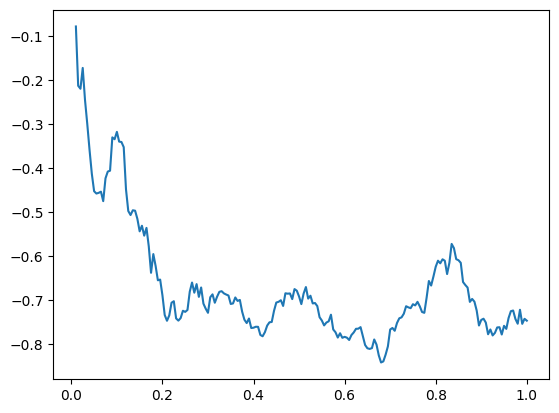

In [1]:
from numpy.random import normal as N
import matplotlib.pyplot as plt
from math import sqrt

m = []
def X(t,DT,sig=1):
    if t-DT<=0: return N(0,t)
    XT= X(t-DT,DT,sig)
    Xt  = XT + (1 + sig *XT)*N(0,sqrt(DT))
    m.append((t,Xt))
    return Xt
X(1,0.005)

x,y =zip(*m)
plt.plot(x,y)
plt.show()

Now also use Euler on the sensitivity equation:
$$
\begin{align*}
d(\partial_{\sigma}X_{t}) &= (X_{t}+ \sigma\partial_{\sigma}X_{t} ) dW_t \Leftrightarrow\\
\partial_{\sigma}X_{t} &= \partial_{\sigma}X_{T} +\int_{T}^{t} (X_{s}+ \sigma\partial_{\sigma}X_{s} ) dW_s \\
& \approx \partial_{\sigma}X_{T} +\int_{T}^{t} (X_{T}+ \sigma\partial_{\sigma}X_{T} ) dW_s \\
& \approx \partial_{\sigma}X_{T} +(X_{T}+ \sigma\partial_{\sigma}X_{T} )\int_{T}^{t}  dW_s \\
& \approx \partial_{\sigma}X_{T} +(X_{T}+ \sigma\partial_{\sigma}X_{T} )N(0,t-T) 
\end{align*}
.
$$ 
we implement this by coupling it to the Euler scheme of the solution. We aren't sure that coupling works in this case.


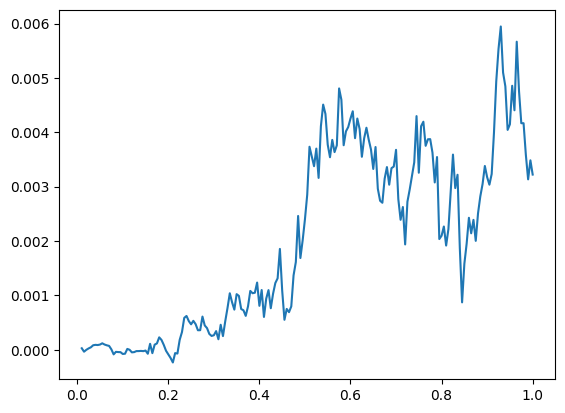

In [145]:
from numpy.random import normal as N
import matplotlib.pyplot as plt

m = []
def E(t,DT,sig=1):
    if t-DT<=0: return (N(0,t),0)
    XT,dXT= E(t-DT,DT,sig)
    Xt = XT + (1 + sig *XT)*N(0,DT)
    dXt = dXT + (XT+ sig*dXT)*N(0,DT) 
    m.append((t,dXt))
    return (Xt,dXt) 

E(1,0.005)
x,y =zip(*m)
plt.plot(x,y)
plt.show()

To test that $\partial_{\sigma}X_{t}$ can be useful we look at the difference between
$X_{t}(\sigma = 1.5)$ and $X_{t}(\sigma = 1) + 0.5 \partial_{\sigma}|_{1} X_{t}$.
 

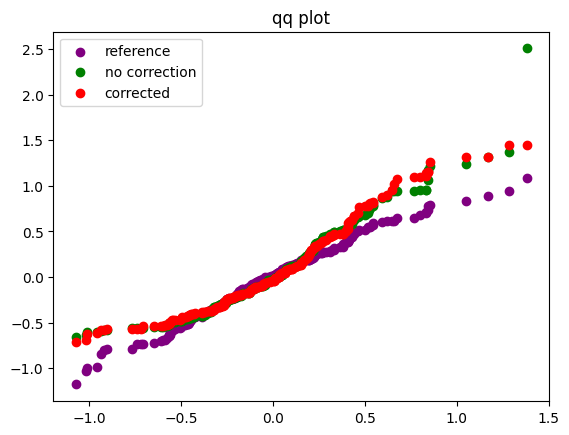

In [15]:
from numpy.random import normal as N
import matplotlib.pyplot as plt

def E(t,DT,sig=1):
    if t-DT<=0: return (N(0,t),0)
    XT,dXT= E(t-DT,DT,sig)
    Xt = XT + (1 + sig *XT)*N(0,DT)
    dXt = dXT + (XT+ sig*dXT)*N(0,DT) 
    return (Xt,dXt) 

t,DT,size =20,0.01,2*10**2
Q  = [E(t,DT,0.1)[0] for _ in range(size)]
Qref  = [E(t,DT,0.1)[0] for _ in range(size)]

S,S_cor = [],[]
for _ in range(size):
    Xt,dXt= E(t,DT,1)
    S.append(Xt)
    S_cor.append(Xt -0.9*dXt)

def pplot(): 
    plt.scatter(sorted(Q),sorted(Qref),color="purple",label ="reference")
    plt.scatter(sorted(Q),sorted(S),color="green",label ="no correction")
    plt.scatter(sorted(Q),sorted(S_cor),color="red",label="corrected")
    plt.title("qq plot")
    plt.legend()
    plt.show()

pplot()

Ok this didn't work maybe we have to make things correlated:

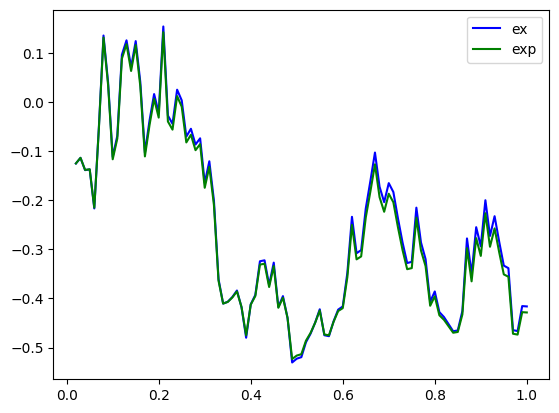

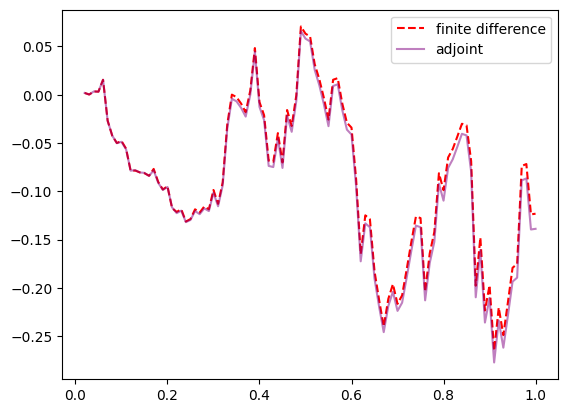

In [3]:
from numpy.random import normal as N
import matplotlib.pyplot as plt

ts,xs,xs2,dxs = [],[],[],[]
def E(t,DT,sig=1,dsig=0.2):
    if t-DT<=0: 
        tmp = N(0,t)
        return (tmp,tmp,0)
    XT,XT2,dXT= E(t-DT,DT,sig,dsig)
    NN = N(0,sqrt(DT))
    Xt = XT + (1 + sig *XT)*NN
    Xt2 = XT2 + (1 + (sig+dsig) *XT2)*NN
    dXt = dXT + (XT+ sig*dXT)*NN 
    ts.append(t)
    xs.append(Xt)
    xs2.append(Xt2)
    dxs.append(dXt)
    return (Xt,Xt2,dXt) 

t,DT,sig,dsig =1,0.01,1,0.1
E(t,DT,sig,dsig)[0] 
zs = [(b-a)/dsig for a,b in zip(xs,xs2)]
plt.plot(ts,xs, color = "blue", label = "ex")
plt.plot(ts,xs2, color = "green", label = "exp")
plt.legend()
plt.show()

plt.plot(ts,zs,color = "red", label = "finite difference",linestyle="dashed")
plt.plot(ts,dxs, color = "purple", label = "adjoint",alpha = 0.5)
plt.legend()
plt.show()


Ok that fixed it